In [1]:
%matplotlib inline

In [2]:
from datetime import datetime
import os
from os.path import dirname, abspath, join
from os import getcwd
import sys

In [3]:
import random
import string
import pandas as pd
import numpy as np

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [5]:
import torch
import socket
from IPython.display import clear_output

In [6]:
# seed_arg = int(sys.argv[1])
# print ("\n\nSeed ARG: ",seed_arg)
seed_arg = 3

In [7]:
seedlist = np.array([161, 314, 228, 271828, 230, 4271031, 5526538, 6610165, 9849252, 34534, 73422, 8765])
seed = seedlist[seed_arg]
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [8]:
LOCATION = 'tokyo'
NAME       = 'V1'+ LOCATION.upper()+datetime.now().strftime("_%H_%M_%S")
MODELNAME  = NAME + '_' + str(seed) + '.pt'
print("\nMODEL : ", NAME)
print("SEED  : ",seed_arg)
print("HOST  : ",socket.gethostname())
print("START : ",datetime.now())


MODEL :  V1TOKYO_12_16_55
SEED  :  3
HOST  :  19c994a59e65
START :  2019-04-13 12:16:55.740832


In [9]:
class ENO(object):
    
    #no. of forecast types is 6 ranging from 0 to 5
  
    def __init__(self, location='tokyo', year=2010, shuffle=False, day_balance=False):
        self.location = location
        self.year = year
        self.day = None
        self.hr = None
        
        self.shuffle = shuffle
        self.day_balance = day_balance

        self.TIME_STEPS = None #no. of time steps in one episode
        self.NO_OF_DAYS = None #no. of days in one year
        
        self.NO_OF_DAYTYPE = 10 #no. of daytypes
        self.daycounter = 0 #to count number of days that have been passed
        
        self.sradiation = None #matrix with GSR for the entire year
        self.senergy = None #matrix with harvested energy data for the entire year
        self.fforecast = None #array with forecast values for each day
        

        self.henergy = None #harvested energy variable
        self.fcast = None #forecast variable
        self.sorted_days = [] #days sorted according to day type
        
        self.SMAX = 1000 # 1 Watt Solar Panel

    
    #function to get the solar data for the given location and year and prep it
    def get_data(self):
        #solar_data/CSV files contain the values of GSR (Global Solar Radiation in MegaJoules per meters squared per hour)
        #weather_data/CSV files contain the weather summary from 06:00 to 18:00 and 18:00 to 06:00+1
        location = self.location
        year = self.year

        THIS_DIR = getcwd()
        SDATA_DIR = abspath(join(THIS_DIR, 'solar_data'))  #abspath(join(THIS_DIR, '../../..', 'data'))
        
        sfile = SDATA_DIR + '/' + location +'/' + str(year) + '.csv'
        
        #skiprows=4 to remove unnecessary title texts
        #usecols=4 to read only the Global Solar Radiation (GSR) values
        solar_radiation = pd.read_csv(sfile, skiprows=4, encoding='shift_jisx0213', usecols=[4])
      
        #convert dataframe to numpy array
        solar_radiation = solar_radiation.values

        #convert missing data in CSV files to zero
        solar_radiation[np.isnan(solar_radiation)] = 0

        #reshape solar_radiation into no_of_daysx24 array
        solar_radiation = solar_radiation.reshape(-1,24)

        if(self.shuffle): #if class instatiation calls for shuffling the day order. Required when learning
            np.random.shuffle(solar_radiation) 
        self.sradiation = solar_radiation
        
        #GSR values (in MJ/sq.mts per hour) need to be expressed in mW
        # Conversion is accomplished by 
        # solar_energy = GSR(in MJ/m2/hr) * 1e6 * size of solar cell * efficiency of solar cell /(60x60) *1000 (to express in mW)
        # the factor of 2 in the end is assuming two solar cells
        self.senergy = 2*self.sradiation * 1e6 * (55e-3 * 70e-3) * 0.15 * 1000/(60*60)

        return 0
    
    #function to map total day radiation into type of day ranging from 0 to 5
    #the classification into day types is quite arbitrary. There is no solid logic behind this type of classification.
    
    def get_day_state(self,tot_day_radiation):
        bin_edges = np.array([0, 3.5, 6.5, 9.0, 12.5, 15.5, 18.5, 22.0, 25, 28])
        for k in np.arange(1,bin_edges.size):
            if (bin_edges[k-1] <= tot_day_radiation <= bin_edges[k]):
                day_state = k -1
                break
            else:
                day_state = bin_edges.size - 1
        return int(day_state)
    
    def get_forecast(self):
        #create a perfect forecaster.
        tot_day_radiation = np.sum(self.sradiation, axis=1) #contains total solar radiation for each day
        get_day_state = np.vectorize(self.get_day_state)
        self.fforecast = get_day_state(tot_day_radiation)
        
        #sort days depending on the type of day and shuffle them; maybe required when learning
        for fcast in range(0,6):
            fcast_days = ([i for i,x in enumerate(self.fforecast) if x == fcast])
            np.random.shuffle(fcast_days)
            self.sorted_days.append(fcast_days)
        return 0
    
    def reset(self,day=0): #it is possible to reset to the beginning of a certain day
        
        self.get_data() #first get data for the given year
        self.get_forecast() #calculate the forecast
        
        self.TIME_STEPS = self.senergy.shape[1]
        self.NO_OF_DAYS = self.senergy.shape[0]
        
        self.day = day
        self.hr = 0
        
        self.henergy = self.senergy[self.day][self.hr]
        self.fcast = self.fforecast[self.day]
        
        end_of_day = False
        end_of_year = False
        return [self.henergy, self.fcast, end_of_day, end_of_year]

    
    def step(self):
        end_of_day = False
        end_of_year = False
        if not(self.day_balance): #if daytype balance is not required
            if(self.hr < self.TIME_STEPS - 1):
                self.hr += 1
                self.henergy = self.senergy[self.day][self.hr] 
                self.fcast = self.fforecast[self.day]
            else:
                if(self.day < self.NO_OF_DAYS -1):
                    end_of_day = True
                    self.hr = 0
                    self.day += 1
                    self.henergy = self.senergy[self.day][self.hr] 
                    self.fcast = self.fforecast[self.day]
                else:
                    end_of_day = True
                    end_of_year = True
                    
        else: #when training, we want all daytypes to be equally represented for robust policy
              #obviously, the days are going to be in random order
            if(self.hr < self.TIME_STEPS - 1):
                self.hr += 1
                self.henergy = self.senergy[self.day][self.hr]
                self.fcast = self.fforecast[self.day]
            else:
                if(self.daycounter < self.NO_OF_DAYS -1):
                    end_of_day = True
                    self.daycounter += 1
                    self.hr = 0
                    daytype = random.choice(np.arange(0,self.NO_OF_DAYTYPE)) #choose random daytype
                    self.day = np.random.choice(self.sorted_days[daytype]) #choose random day from that daytype
                    self.henergy = self.senergy[self.day][self.hr] 
                    self.fcast = self.fforecast[self.day]
                else: 
                    end_of_day = True
                    end_of_year = True
                    self.daycounter = 0
        
        return [self.henergy, self.fcast, end_of_day, end_of_year]

In [10]:
class CAPM (object):
    def __init__(self,location='tokyo', year=2010, shuffle=False, trainmode=False):

        #all energy values i.e. BMIN, BMAX, BOPT, HMAX are in mWhr. Assuming one timestep is one hour
        
        self.BMIN = 0.0                #Minimum battery level that is tolerated. Maybe non-zero also
        self.BMAX = 10000.0            #Max Battery Level. May not necessarily be equal to total batter capacity [3.6V x 2500mAh]
        self.BOPT = 0.5 * self.BMAX    #Optimal Battery Level. Assuming 50% of battery is the optimum
        self.BLIM_LO = 0.15*self.BMAX
        self.BLIM_HI = 0.85*self.BMAX
        self.BSAFE_LO = 0.35*self.BMAX
        self.BSAFE_HI = 0.65*self.BMAX
        
        self.ENP_MARGIN = 0.3*self.BMAX

        
        self.HMIN = 0      #Minimum energy that can be harvested by the solar panel.
        self.HMAX = None   #Maximum energy that can be harvested by the solar panel. [500mW]
        
        self.DMAX = 500      #Maximum energy that can be consumed by the node in one time step. [~ 3.6V x 135mA]
        self.N_ACTIONS = 10  #No. of different duty cycles possible
        self.DMIN = self.DMAX/self.N_ACTIONS #Minimum energy that can be consumed by the node in one time step. [~ 3.6V x 15mA]
        
        self.binit = None     #battery at the beginning of day
        self.btrack = []      #track the battery level for each day
        self.v_btrack = []      #track the virtual battery level for each day

        self.atrack = []      #track the duty cycles for each day
        self.htrack = []      #track the harvested for each day
        self.batt = None      #battery variable
        self.enp = None       #enp at end of hr
        self.henergy = None   #harvested energy variable
        self.fcast = None     #forecast variable
        
        self.MUBATT = 0.6
        self.SDBATT = 0.02
        
        self.MUHENERGY = 0.5
        self.SDHENERGY = 0.2
        
        self.MUENP = 0
        self.SDENP = 0.02
        
        self.location  = location
        self.year      = year
        self.shuffle   = shuffle
        self.trainmode = trainmode
        self.eno       = None
        
        self.day_violation_flag = False
        self.violation_flag     = False
        self.violation_counter  = 0
        self.batt_full_counter  = 0
        self.batt_empty_counter = 0
        
        self.batt_violations    = 0

        self.NO_OF_DAYTYPE      = 10 #no. of daytypes
 
    def reset(self,day=0,batt=-1):
        henergy, fcast, day_end, year_end = self.eno.reset(day) #reset the eno environment
        self.violation_flag = False
        self.violation_counter = 0
        self.batt_violations = 0
        
        if(batt == -1):
            self.batt = self.BOPT
        else:
            self.batt = batt
            
        self.batt = np.clip(self.batt, self.BMIN, self.BMAX)
        self.binit = self.batt
        self.btrack = np.append(self.btrack, self.batt) #track battery levels
        self.v_btrack = np.append(self.v_btrack, self.batt) #track battery levels
#         self.enp = self.BOPT - self.batt
        self.enp = self.binit - self.batt #enp is calculated
        self.henergy = np.clip(henergy, self.HMIN, self.HMAX) #clip henergy within HMIN and HMAX
        self.fcast = fcast
        
        norm_batt    = self.batt    /self.BMAX
        norm_enp     = self.enp     /self.BMAX
        norm_henergy = self.henergy /self.HMAX
        norm_fcast   = self.fcast   /(self.NO_OF_DAYTYPE-1)
        c_state = [norm_batt, norm_enp, norm_henergy, norm_fcast] #continuous states

        reward = 0
        
        return [c_state, reward, day_end, year_end]
    
    def getstate(self): #query the present state of the system
        norm_batt    = self.batt    /self.BMAX
        norm_enp     = self.enp     /self.BMAX
        norm_henergy = self.henergy /self.HMAX
        norm_fcast   = self.fcast   /(self.NO_OF_DAYTYPE-1)
        c_state = [norm_batt, norm_enp, norm_henergy, norm_fcast] #continuous states

        return c_state
        
    
    #reward function
    def rewardfn(self):
        violation_penalty = 0
        bmean = self.v_btrack.mean()
        bdev = self.BOPT - bmean
        if np.abs(bdev) > (self.BOPT - 0.25*self.BMAX):
            reward = 1.5-np.abs(bdev)/self.BMAX*5
        else:
            reward = 2
#         reward = 2 - 20*np.abs(bdev)/self.BMAX
        if(self.day_violation_flag):
            violation_penalty += 3    #penalty for violating battery limits anytime during the day
        return (reward - violation_penalty)
    
    
    
    def step(self, action):
        day_end = False
        year_end = False
        self.violation_flag = False
        reward = 0
        self.atrack = np.append(self.atrack, action+1) #track duty cycles
        self.htrack = np.append(self.htrack, self.henergy)

#         action_var = np.abs(np.mean(self.atrack) - action)/9 #can vary from 0 to 1
#         reward += 0.25*(0.5 - action_var ) #reward penalizing high duty cycle variance [-0.5 to 0.5]*0.25
      
        action = np.clip(action, 0, self.N_ACTIONS-1) #action values range from (0 to N_ACTIONS-1)
        e_consumed = (action+1)*self.DMAX/self.N_ACTIONS   #energy consumed by the node
        
        
        self.batt += (self.henergy - e_consumed)
        
        v_batt = self.binit + self.htrack.sum() - self.atrack.sum()*self.DMAX/self.N_ACTIONS
        self.v_btrack = np.append(self.v_btrack, v_batt) #track battery levels
        
        if(self.batt <= self.BMIN or self.batt >= self.BMAX ):
                self.batt_violations += 1
        
        if(self.batt <= self.BMIN or self.batt >= self.BMAX ):
#         if(self.batt < self.BLIM_LO or self.batt > self.BLIM_HI ):
            self.violation_flag = True #penalty for violating battery limits everytime it happens
#             reward -= 2
#             if(self.batt < self.BLIM_LO): #battery depletion is more fatal than battery overflow
#                 reward -= 2

        if(self.batt <= self.BMIN ): 
            self.batt_empty_counter += 1
        if(self.batt >= self.BMAX ): 
            self.batt_full_counter  += 1

        if(self.violation_flag):
            if(self.day_violation_flag == False): #penalty for violating battery limits anytime during the day - triggers once everyday
                self.violation_counter += 1
                self.day_violation_flag = True
                
        #calculate ENP before clipping
#         self.enp = self.BOPT - self.batt
        self.enp = self.binit - self.batt
        
        self.batt = np.clip(self.batt, self.BMIN, self.BMAX) #clip battery values within permitted level
        self.btrack = np.append(self.btrack, self.batt) #track battery levels
        
        
        #proceed to the next time step
       
        self.henergy, self.fcast, day_end, year_end = self.eno.step()
        self.henergy = np.clip(self.henergy, self.HMIN, self.HMAX) #clip henergy within HMIN and HMAX
                        
        if(day_end): #if eno object flags that the day has ended then give reward
            reward += self.rewardfn()
            if (self.trainmode): #reset battery to optimal level if limits are exceeded when training
#                 self.batt = np.random.uniform(self.DMAX*self.eno.TIME_STEPS/self.BMAX,0.8)*self.BMAX
#                 if (self.violation_flag):
                if np.random.uniform() < HELP : #occasionaly reset the battery
                    self.batt = self.BOPT  
            
            self.day_violation_flag = False
            self.binit = self.batt #this will be the new initial battery level for next day
            self.btrack = [] #clear battery tracker
            self.v_btrack = [] #clear battery tracker
            self.atrack = [] #clear duty cycle tracker
            self.htrack = [] #clear henergy tracker
   
        norm_batt    = self.batt    /self.BMAX
        norm_enp     = self.enp     /self.BMAX
        norm_henergy = self.henergy /self.HMAX
        norm_fcast   = self.fcast   /(self.NO_OF_DAYTYPE-1)
        c_state = [norm_batt, norm_enp, norm_henergy, norm_fcast] #continuous states
        
        return [c_state, reward, day_end, year_end]

In [11]:
# Hyper Parameters
BATCH_SIZE          = 32
WT_DECAY            = None
LR                  = 1e-4          # learning rate
EPSILON             = 0.9           # greedy policy
GAMMA               = 0.99           # reward discount
LAMBDA              = 0.95          # parameter decay
TARGET_REPLACE_ITER = 24*7*4*18     # target update frequency
MEMORY_CAPACITY     = 24*7*4*12*3   # store upto six month worth of memory   

N_ACTIONS           = 10            # no. of duty cycles (0,1,2,3,4)
N_STATES            = 4             # number of state space parameter [batt, enp, henergy, fcast]

HIDDEN_LAYER        = 50            # width of NN
NO_OF_ITERATIONS    = 10
GPU                 = False         # device
HELP                = 0.05

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

#Class definitions for NN model and learning algorithm
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class DQN(object):
    def __init__(self):
        if(GPU): 
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        else:
            device = torch.device('cpu')
        self.eval_net, self.target_net = Net(), Net()
        self.eval_net.to(device)
        self.target_net.to(device)
        self.device = device
#         print("Neural net")
#         print(self.eval_net)
        self.learn_step_counter = 0                                     # for target updating
        self.memory_counter = 0                                         # for storing memory
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))     # initialize memory [mem: ([s], a, r, [s_]) ]
#         self.optimizer = torch.optim.RMSprop(self.eval_net.parameters(), lr=LR, alpha=0.95, eps=1e-2, weight_decay=0, momentum=0, centered=False)
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)

        self.running_loss = 0.0
        
        
#         self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)
#         self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR, weight_decay=WT_DECAY)
#         self.loss_func = nn.SmoothL1Loss()
        self.loss_func = nn.MSELoss()
        self.nettoggle = False

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        x = x.to(self.device)

        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.to(torch.device("cpu"))
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] # return the argmax index
        if np.random.uniform() > EPSILON:   # greedy
            action += np.random.randint(-3, 3)
            action = int(np.clip(action, 0, N_ACTIONS-1))
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        x = x.to(self.device)

        # input only one sample
        if True:   # greedy
            actions_value = self.eval_net.forward(x)
            actions_value = actions_value.to(torch.device("cpu"))
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] # return the argmax index
        return action

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, [a, r], s_))
        # replace the old memory with new memory
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1
    
    def store_day_transition(self, transition_rec):
        data = transition_rec
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory= np.insert(self.memory, index, data,0)
        self.memory_counter += transition_rec.shape[0]

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
            self.nettoggle = not self.nettoggle
        self.learn_step_counter += 1

        # sample batch transitions
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        b_memory = self.memory[sample_index, :]
        b_s = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])
        
        b_s = b_s.to(self.device)
        b_a = b_a.to(self.device)
        b_r = b_r.to(self.device)
        b_s_ = b_s_.to(self.device)

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER))
            self.running_loss = 0.0

In [13]:
def stdize(s):
    MU_BATT = 0.5
    SD_BATT = 0.5
    
    MU_ENP = 0
    SD_ENP = 0.5
    
    MU_HENERGY = 0.35
    SD_HENERGY = 0.55
    
    MU_FCAST = 0.5
    SD_FCAST = 0.6
    
    norm_batt, norm_enp, norm_henergy, norm_fcast = s
    
    std_batt    = (norm_batt    - MU_BATT    )/SD_BATT
    std_enp     = (norm_enp     - MU_ENP     )/SD_ENP
    std_henergy = (norm_henergy - MU_HENERGY )/SD_HENERGY
    std_fcast   = (norm_fcast   - MU_FCAST   )/SD_FCAST

    return [std_batt, std_enp, std_henergy, std_fcast]


In [14]:
#CONSTANTS
LOCATION = 'tokyo'
YEAR = 2010
capm      = CAPM(LOCATION,YEAR,shuffle=False, trainmode=False) #instantiate the CAPM class
print("BMIN       = ", capm.BMIN)
print("BMAX       = ", capm.BMAX)
print("BOPT       = ", capm.BOPT)
print("BLIM_LO    = ", capm.BLIM_LO)
print("BLIM_HI    = ", capm.BLIM_HI)
print("BSAFE_LO   = ", capm.BSAFE_LO)
print("BSAFE_HI   = ", capm.BSAFE_HI)
print("ENP_MARGIN = ", capm.ENP_MARGIN)

BMIN       =  0.0
BMAX       =  10000.0
BOPT       =  5000.0
BLIM_LO    =  1500.0
BLIM_HI    =  8500.0
BSAFE_LO   =  3500.0
BSAFE_HI   =  6500.0
ENP_MARGIN =  3000.0


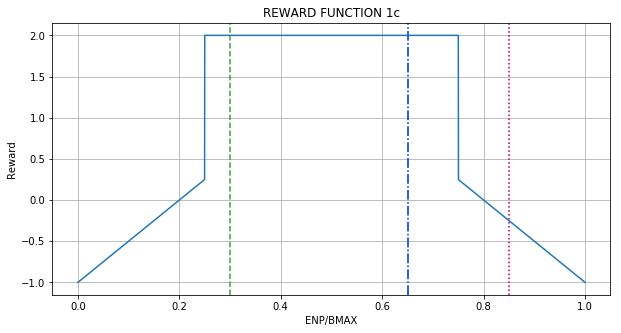

RF_1c(0)            =  -1.00
RF_1c(ENP_MARGIN/4) =  -1.00
RF_1c(ENP_MARGIN/2) =  -1.00
RF_1c(ENP_MARGIN)   =  -1.00

RF_1c(BMAX/2) =  -1.00
RF_1c(BMAX)   =  -1.00



In [15]:
#PLOT REWARD FUNCTIONS
x = np.arange(0,capm.BMAX)
y = np.array([capm.rewardfn() for capm.v_btrack in x])

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_title('REWARD FUNCTION 1c')
ax.set_xlabel('ENP/BMAX')
ax.set_ylabel('Reward')
ax.axvline((capm.ENP_MARGIN)/capm.BMAX, color='g',alpha=0.75, linestyle='--')
ax.axvline(1-(capm.BSAFE_LO)/capm.BMAX, color='c',alpha=0.75, linestyle='-.')
ax.axvline(  (capm.BSAFE_HI)/capm.BMAX, color='b',alpha=0.75, linestyle="-.")
ax.axvline(1- (capm.BLIM_LO)/capm.BMAX, color='r',alpha=0.75, linestyle=':')
ax.axvline(   (capm.BLIM_HI)/capm.BMAX, color='m',alpha=0.75, linestyle=":")
ax.plot(x/capm.BMAX,y)
ax.grid(True)
plt.show()

capm.enp = 0;            print("RF_1c(0)            = {:6.2f}".format(capm.rewardfn()) )
capm.enp = capm.ENP_MARGIN/4; print("RF_1c(ENP_MARGIN/4) = {:6.2f}".format(capm.rewardfn()) )
capm.enp = capm.ENP_MARGIN/2; print("RF_1c(ENP_MARGIN/2) = {:6.2f}".format(capm.rewardfn()) )
capm.enp = capm.ENP_MARGIN;   print("RF_1c(ENP_MARGIN)   = {:6.2f}".format(capm.rewardfn()) )
print("");
capm.enp = capm.BMAX/2; print("RF_1c(BMAX/2) = {:6.2f}".format(capm.rewardfn()) )
capm.enp = capm.BMAX;   print("RF_1c(BMAX)   = {:6.2f}".format(capm.rewardfn()) )
print("");

In [16]:
#TRAINING STARTS
tic = datetime.now()

Device:  cpu

Iteration 0:  TOKYO, 2002 
EPSILON = 5.000e-01
LR = 1.000e-04
Average Terminal Reward  = -2.712
Day Violations           =    269
Battery Limit Violations =   3311
Battery FULL Violations  =     79
Battery EMPTY Violations =   3232
MAX NN INPUTS:   1.000   1.127   1.182   0.833
MIN NN INPUTS:  -1.000  -1.618  -0.636  -0.833


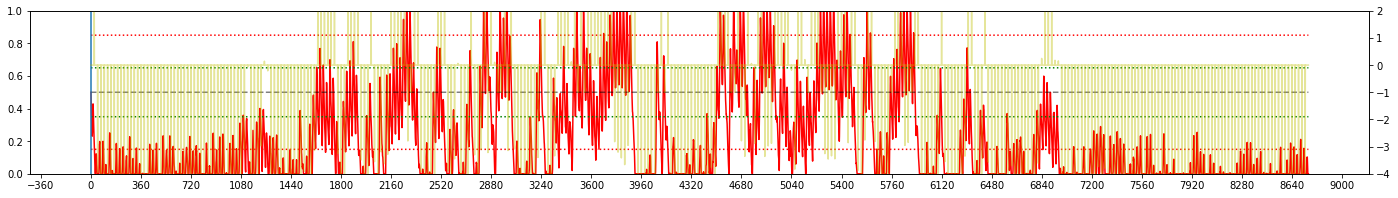


Iteration 1:  TOKYO, 2001 
EPSILON = 5.000e-01
LR = 1.000e-04
Average Terminal Reward  = -3.172
Day Violations           =    292
Battery Limit Violations =   3445
Battery FULL Violations  =     96
Battery EMPTY Violations =   3349
MAX NN INPUTS:   1.000   1.080   1.182   0.648
MIN NN INPUTS:  -1.000  -1.345  -0.636  -0.833


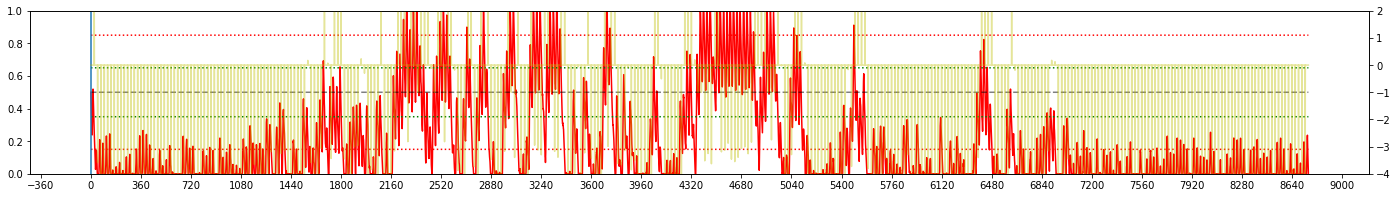


Iteration 2:  TOKYO, 2006 
EPSILON = 5.000e-01
LR = 1.000e-04
Average Terminal Reward  = -3.621
Day Violations           =    306
Battery Limit Violations =   3947
Battery FULL Violations  =     22
Battery EMPTY Violations =   3925
MAX NN INPUTS:   1.000   1.129   1.182   0.648
MIN NN INPUTS:  -1.000  -1.502  -0.636  -0.833


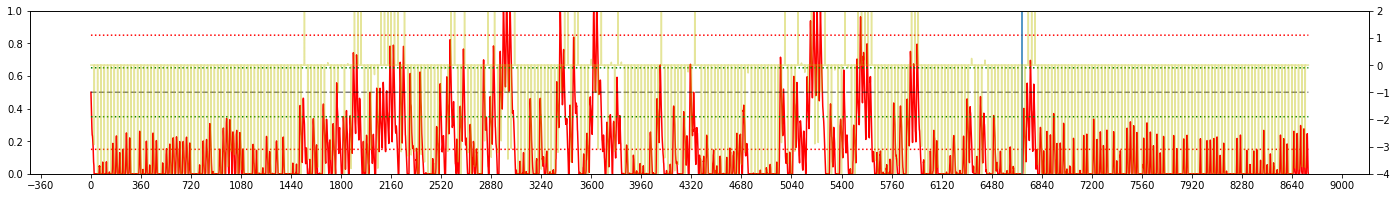


Iteration 3:  TOKYO, 2000 
EPSILON = 5.000e-01
LR = 1.000e-04
Average Terminal Reward  =  0.565
Day Violations           =     80
Battery Limit Violations =    374
Battery FULL Violations  =    252
Battery EMPTY Violations =    122
MAX NN INPUTS:   1.000   0.926   1.182   0.648
MIN NN INPUTS:  -1.000  -1.295  -0.636  -0.833


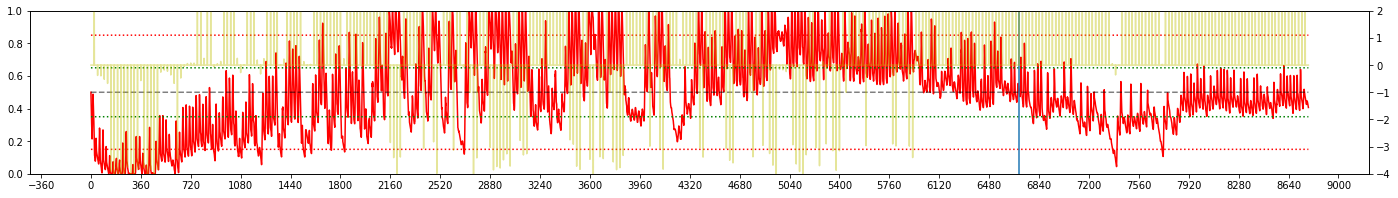

LOSS : 2.864

Iteration 4:  TOKYO, 2002 
EPSILON = 5.001e-01
LR = 1.000e-04
Average Terminal Reward  =  1.620
Day Violations           =     26
Battery Limit Violations =     77
Battery FULL Violations  =     77
Battery EMPTY Violations =      0
MAX NN INPUTS:   1.000   0.615   1.182   0.833
MIN NN INPUTS:  -0.935  -1.224  -0.636  -0.833


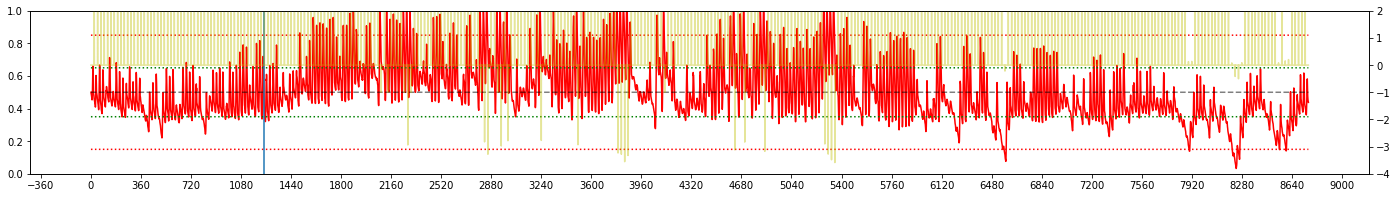

LOSS : 1.688

Iteration 5:  TOKYO, 2003 
EPSILON = 5.001e-01
LR = 1.000e-04
Average Terminal Reward  =  1.837
Day Violations           =      6
Battery Limit Violations =     46
Battery FULL Violations  =      5
Battery EMPTY Violations =     41
MAX NN INPUTS:   1.000   0.630   1.182   0.833
MIN NN INPUTS:  -1.000  -1.241  -0.636  -0.833


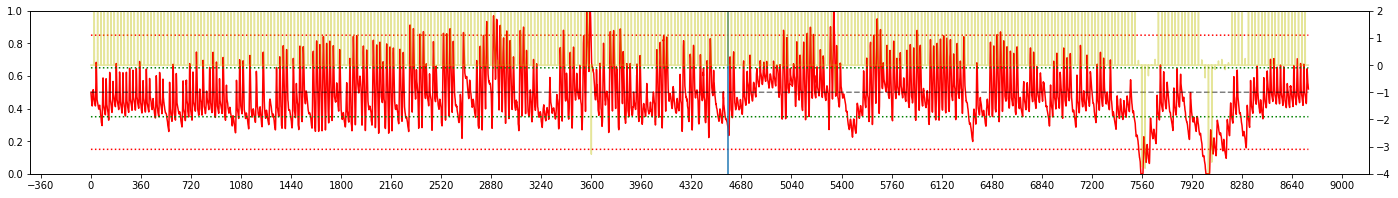

LOSS : 1.410

Iteration 6:  TOKYO, 2000 
EPSILON = 5.001e-01
LR = 1.000e-04
Average Terminal Reward  =  1.831
Day Violations           =     10
Battery Limit Violations =     36
Battery FULL Violations  =     36
Battery EMPTY Violations =      0
MAX NN INPUTS:   1.000   0.997   1.182   0.648
MIN NN INPUTS:  -0.828  -1.227  -0.636  -0.833


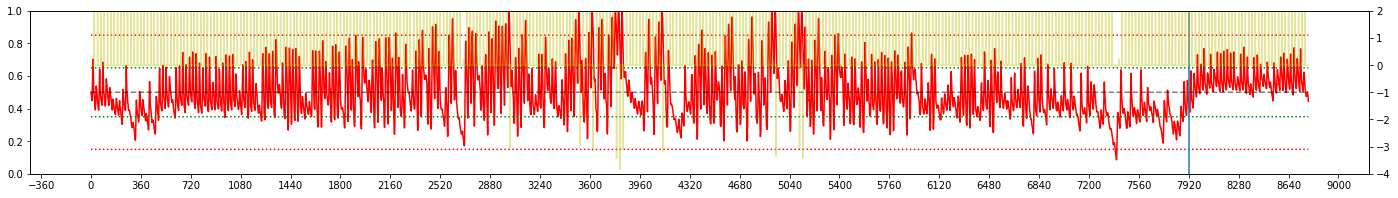


Iteration 7:  TOKYO, 2002 
EPSILON = 5.001e-01
LR = 1.000e-04
Average Terminal Reward  =  1.865
Day Violations           =      5
Battery Limit Violations =     31
Battery FULL Violations  =      9
Battery EMPTY Violations =     22
MAX NN INPUTS:   1.000   1.155   1.182   0.833
MIN NN INPUTS:  -1.000  -1.227  -0.636  -0.833


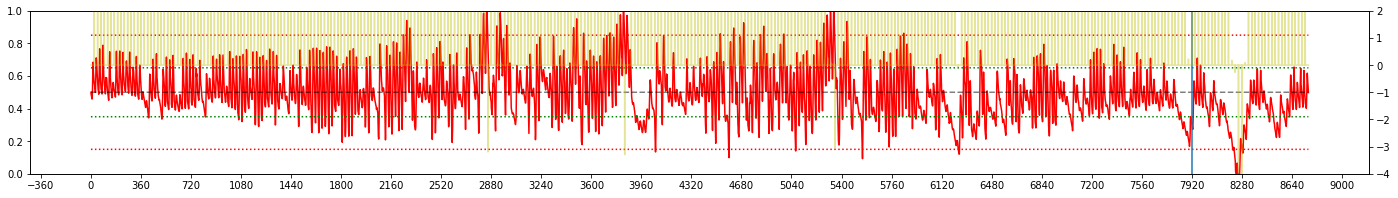

LOSS : 1.283

Iteration 8:  TOKYO, 2000 
EPSILON = 5.001e-01
LR = 1.000e-04
Average Terminal Reward  =  1.905
Day Violations           =      5
Battery Limit Violations =      8
Battery FULL Violations  =      8
Battery EMPTY Violations =      0
MAX NN INPUTS:   1.000   1.077   1.182   0.648
MIN NN INPUTS:  -0.798  -1.257  -0.636  -0.833


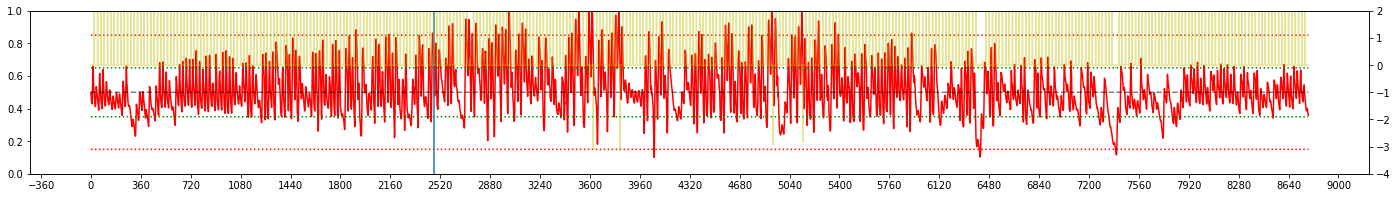

LOSS : 0.931

Iteration 9:  TOKYO, 2008 
EPSILON = 5.001e-01
LR = 1.000e-04
Average Terminal Reward  =  1.971
Day Violations           =      1
Battery Limit Violations =      2
Battery FULL Violations  =      2
Battery EMPTY Violations =      0
MAX NN INPUTS:   1.000   0.922   1.182   0.833
MIN NN INPUTS:  -0.654  -1.243  -0.636  -0.833


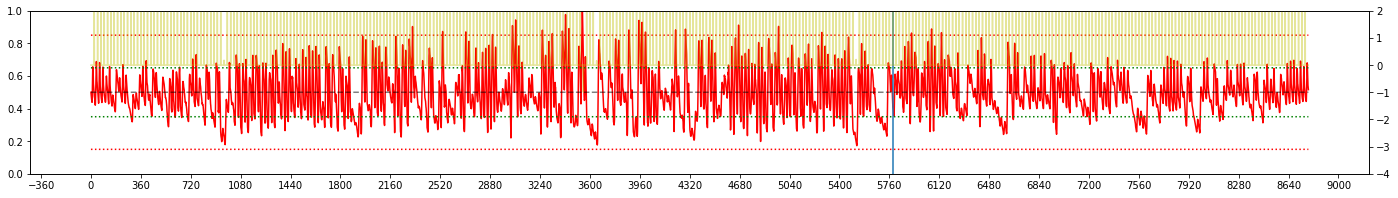

In [17]:
#TRAIN 
dqn = DQN()
# # for recording weights
# oldfc1 = dqn.eval_net.fc1.weight.data.cpu().numpy().flatten()
# old2fc1 = oldfc1

# # oldfc2 = dqn.eval_net.fc2.weight.data.cpu().numpy().flatten()
# # old2fc2 = oldfc2

# # oldfc3 = dqn.eval_net.fc3.weight.data.cpu().numpy().flatten()
# # old2fc3 = oldfc3

# oldout = dqn.eval_net.fc_out.weight.data.cpu().numpy().flatten()
# old2out = oldout
# ########################################

change_hr = 0 #when dqn target_net is updated by eval_net
avg_reward_rec = [] #record the yearly average rewards over the entire duration of training
batt_violation_rec = []
day_violation_rec = []

print('Device: ', dqn.device)
#TRAINING STARTS
tic = datetime.now()

e_rec = []
lr_rec = []
for iteration in range(NO_OF_ITERATIONS):
    max_b       = 0
    max_enp     = 0
    max_henergy = 0
    max_fcast   = 0
    
    min_b       = 0
    min_enp     = 0
    min_henergy = 0
    min_fcast   = 0
    # EPSILON SCHEDULING
#     EXPLORE_MAX  = 1.0
#     EXPLORE_MIN  = 0.005
#     E_DECAY_RATE = 0.1
#     EPSILON      = 1 - (EXPLORE_MIN + (EXPLORE_MAX - EXPLORE_MIN)*np.exp(-E_DECAY_RATE*iteration))

    e_slope = 5
    e_start = 0.5
    e_inflection_point = 50
    EPSILON = e_start + (1-e_start)/(1 + np.exp(-(iteration-e_inflection_point)/e_slope))

    e_rec        = np.append(e_rec,EPSILON)


    # LR SCEHDULING
#     LR_START      = 2.5E-5
#     LR_END        = 1E-6
#     L_DECAY_RATE  = 0.03
#     lrate         = LR_END + (LR_START - LR_END)*np.exp(-L_DECAY_RATE*iteration)
#     dqn.optimizer = torch.optim.RMSprop(dqn.eval_net.parameters(), lr=lrate, alpha=0.95, eps=1e-2, weight_decay=0, momentum=0, centered=False)

#     lr_slope = 3
#     lr_start = 0
#     lr_inflection_point = 2
#     if iteration <=50:
#         lrate =  (lr_start + (1-lr_start)/(1 + np.exp(-(iteration-lr_inflection_point)/lr_slope)))*1e-4
#     else:
#         lrate = 0.95*(lrate-lrate*0.1)+0.2*1e-5
#     dqn.optimizer = torch.optim.Adam(dqn.eval_net.parameters(), lr=lrate)
    lrate = LR
    lr_rec        = np.append(lr_rec,lrate)

    LOCATION    = 'tokyo'#random.choice(['tokyo','wakkanai','minamidaito'])
    YEAR        = random.choice(np.arange(2000,2010))
    
    capm        = CAPM(LOCATION,YEAR,shuffle=False, trainmode=False) #instantiate the CAPM class
    capm.eno    = ENO(LOCATION,YEAR, shuffle=False, day_balance=False) #instantiate the environment inside the CAPM class
    capm.HMAX   = capm.eno.SMAX #maximum power output of solar cell is set in CAPM object using the value in ENO object


    s, r, day_end, year_end = capm.reset()
    yr_record      = np.empty(4)
    transition_rec = np.zeros((capm.eno.TIME_STEPS, N_STATES * 2 + 2)) #record all the transition in one day

    while True:
        
        s0, s1, s2, s3 = stdize(s)
#         print(s3)
#         print(s0,s1,s2,s3)
        max_b       = max(max_b,s0)
        max_enp     = max(max_enp,s1)
        max_henergy = max(max_henergy,s2)
        max_fcast   = max(max_fcast,s3)
        
        min_b       = min(min_b,s0)
        min_enp     = min(min_enp,s1)
        min_henergy = min(min_henergy,s2)
        min_fcast   = min(min_fcast,s3)
        
        
        a = dqn.choose_action(stdize(s))
        yr_record = np.vstack((yr_record, [s[0],s[2],r, a]))
        
        # take action
        s_, r, day_end, year_end = capm.step(a)
        
        temp_transitions                = np.hstack((stdize(s), [a, r], stdize(s_)))
        transition_rec[capm.eno.hr-1,:] = temp_transitions

        if (day_end):
            transition_rec[:,5]  = r #broadcast reward to all states
#             decay_factor         = [i for i in (LAMBDA**n for n in reversed(range(0, capm.eno.TIME_STEPS)))]
#             transition_rec[:,5]  = transition_rec[:,5] * decay_factor #decay reward proportionately
            dqn.store_day_transition(transition_rec)

        if dqn.memory_counter > MEMORY_CAPACITY:
            dqn.learn()

        if dqn.nettoggle:
            change_hr = capm.eno.day*24+capm.eno.hr #to mark when the DQN is updated.
            dqn.nettoggle = not dqn.nettoggle

        if (year_end):
            break

        # transition to new state
        s = s_

    yr_record = np.delete(yr_record, 0, 0)     #remove the first row which is garbage
    hourly_yr_reward_rec = yr_record[:,2]      #extract reward information from the record array
    yr_reward_rec = hourly_yr_reward_rec[::24] #only consider terminal rewards

    print('\nIteration {}:  {}, {} '.format(iteration, LOCATION.upper(), YEAR))
    print('EPSILON = {:6.3e}'.format(EPSILON))
    for param_group in dqn.optimizer.param_groups:
        print('LR = {:6.3e}'.format(param_group['lr']))
    print("Average Terminal Reward  = {:6.3f}".format(np.mean(yr_reward_rec)))
    print("Day Violations           = {:6d}".format(capm.violation_counter))
    print("Battery Limit Violations = {:6d}".format(capm.batt_violations))
    print("Battery FULL Violations  = {:6d}".format(capm.batt_full_counter))
    print("Battery EMPTY Violations = {:6d}".format(capm.batt_empty_counter))
    print("MAX NN INPUTS: %7.3f %7.3f %7.3f %7.3f" %(max_b,max_enp,max_henergy, max_fcast))
    print("MIN NN INPUTS: %7.3f %7.3f %7.3f %7.3f" %(min_b,min_enp,min_henergy, min_fcast))

#     print("Action MEAN              = {:6.3f}".format(np.mean(yr_record[:,-1] + 1)))
#     print("Action STD DEV           = {:6.3f}".format(np.std(yr_record[:,-1] + 1)))
   
    # Log the average reward in avg_reward_rec to plot later in the learning curve graph figure
    avg_reward_rec      = np.append(avg_reward_rec, np.mean(yr_reward_rec))
    day_violation_rec   = np.append(day_violation_rec, capm.violation_counter)
    batt_violation_rec  = np.append(batt_violation_rec, capm.batt_violations)

# ###########################################################################################
# ###########################################################################################
# #   PLOT battery levels, hourly rewards and the weights
    
    #PLOT BATTERY AND REWARD
    fig = plt.figure(figsize=(24,3))
    TIME_STEPS = capm.eno.TIME_STEPS
    NO_OF_DAYS = capm.eno.NO_OF_DAYS
    DAY_SPACING = 15
    TICK_SPACING = TIME_STEPS*DAY_SPACING
    
    #plot battery
    ax = fig.add_subplot(111)
    ax.plot(np.arange(0,TIME_STEPS*NO_OF_DAYS),  yr_record[:,0],'r')
    ax.plot(np.arange(0,TIME_STEPS*NO_OF_DAYS), np.ones_like(yr_record[:,0])*capm.BOPT/capm.BMAX, 'k--', alpha=0.5)
    ax.plot(np.arange(0,TIME_STEPS*NO_OF_DAYS), np.ones_like(yr_record[:,0])*capm.BLIM_LO/capm.BMAX, 'r:')
    ax.plot(np.arange(0,TIME_STEPS*NO_OF_DAYS), np.ones_like(yr_record[:,0])*capm.BLIM_HI/capm.BMAX, 'r:')
    ax.plot(np.arange(0,TIME_STEPS*NO_OF_DAYS), np.ones_like(yr_record[:,0])*(capm.BOPT+capm.ENP_MARGIN /2) /capm.BMAX, 'g:')
    ax.plot(np.arange(0,TIME_STEPS*NO_OF_DAYS), np.ones_like(yr_record[:,0])*(capm.BOPT-capm.ENP_MARGIN/2)/capm.BMAX, 'g:')
    ax.set_ylim([0,1])
    ax.axvline(x=change_hr)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(TICK_SPACING))

    #plot hourly reward
    ax0 = ax.twinx()
    ax0.plot(hourly_yr_reward_rec, color='y',alpha=0.4)
    ax0.set_ylim(-4,2)
    
    plt.show()
# # #################################################################
#     # PLOT WEIGHTS
#     fig = plt.figure(figsize=(18,6))

#     ax1 = fig.add_subplot(211)
#     newfc1 = dqn.eval_net.fc1.weight.data.cpu().numpy().flatten()
#     xaxis = np.arange(0,newfc1.shape[0])
#     ax1.bar(xaxis, old2fc1, color='b', alpha = 0.3)
#     ax1.bar(xaxis, oldfc1,  color='b', alpha = 0.5)
#     ax1.bar(xaxis, newfc1,  color='b', alpha = 1.0)
#     ax1.set_title("FC1")
# #     ax1.set_ylim([-4,4])
#     ax1.set_ylabel("Weight Value")

#     axO = fig.add_subplot(212)
#     newout = dqn.eval_net.fc_out.weight.data.cpu().numpy().flatten()
#     xaxis = np.arange(0,newout.shape[0])
#     axO.bar(xaxis, old2out, color='g', alpha = 0.3)
#     axO.bar(xaxis, oldout,  color='g', alpha = 0.5)
#     axO.bar(xaxis, newout,  color='g', alpha = 1.0)
#     axO.set_title("FC OUT")
# #     axO.set_ylim([-4,4])
#     axO.set_ylabel("Weight Value")

#     fig.tight_layout()
#     plt.show()
# # #################################################################

#     # PLOT HISTOGRAM OF WEIGHTS
#     fig = plt.figure(figsize=(18,6))

#     ax1 = fig.add_subplot(211)
#     newfc1 = dqn.eval_net.fc1.weight.data.cpu().numpy().flatten()
#     xaxis = np.arange(0,newfc1.shape[0])
# #     ax1.hist(old2fc1, density = False, bins=HIDDEN_LAYER, rwidth=0.95, color='b' , alpha = 0.1 )
# #     ax1.hist(oldfc1,  density = False, bins=HIDDEN_LAYER, rwidth=0.95, color='b' , alpha = 0.3 )
#     ax1.hist(newfc1,  density = False, bins=HIDDEN_LAYER, rwidth=0.95, color='b' , alpha = 0.6 )
#     ax1.set_title("FC1")
#     ax1.set_xlabel("Weight Value")


#     axO = fig.add_subplot(212)
#     newout = dqn.eval_net.fc_out.weight.data.cpu().numpy().flatten()
#     xaxis = np.arange(0,newout.shape[0])
# #     axO.hist(old2out, density = False, bins=HIDDEN_LAYER, rwidth=0.95, color='g' , alpha = 0.1)
# #     axO.hist(oldout,  density = False, bins=HIDDEN_LAYER, rwidth=0.95, color='g' , alpha = 0.3)
#     axO.hist(newout,  density = False, bins=HIDDEN_LAYER, rwidth=0.95, color='g' , alpha = 0.6)
#     axO.set_title("FC OUT")
#     axO.set_xlabel("Weight Value")


#     fig.tight_layout()
#     plt.show()
# # #################################################################    
    
#     old2fc1 = oldfc1
#     oldfc1 = newfc1
    
#     old2out = oldout
#     oldout = newout

    # End of training

In [18]:
print('Train time: {}\n'.format(datetime.now() - tic))
torch.save(dqn.eval_net.state_dict(), './models/'+ 'demo_' + MODELNAME)

Train time: 0:02:50.187575



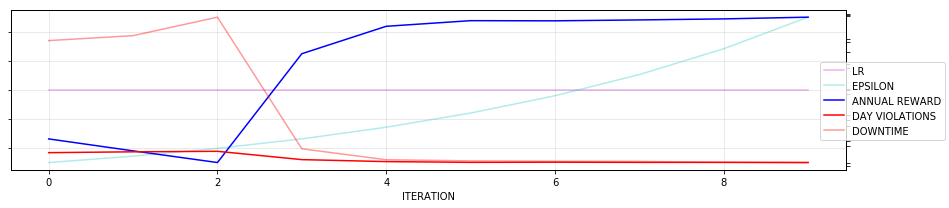

In [19]:
###########################################################################################
###########################################################################################

#PLOT LR AND EPSILON SCHEDULING
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(111)
# ax.set_title("LR and EPSILON SCHEDULING V3")
ax.set_xlabel("ITERATION")
# ax.set_ylabel("LR",      color = 'm')
ax.plot(lr_rec,          color = 'm', alpha = 0.3,label="LR")
# ax.tick_params(axis='y', color = 'm')
# ax.ticklabel_format(style='sci', axis='y', scilimits=(-6,-7))
# ax.minorticks_on()

# ax.set_axisbelow(True)
ax.yaxis.set_ticklabels([])

ax.grid(b=True, which='minor', linestyle=':',  color='k', alpha = 0.1)
ax.grid(b=True, which='major', linestyle='-',  color='k', alpha = 0.1)

ax_ = ax.twinx()
# ax_.set_ylabel("EPSILON", color = 'c')
# ax_.tick_params(axis='y', color = 'c')
# ax_.set_axisbelow(True)
# ax_.minorticks_on()
ax_.plot(e_rec,           color = 'c', alpha = 0.3, label="EPSILON")
ax_.yaxis.set_ticklabels([])

# Plot the average reward log
ax1 = ax.twinx()
# ax1.set_ylabel("Terminal Reward", color = 'b')
# ax1.set_ylim([-10,2]);
ax1.plot(avg_reward_rec,'b',label="ANNUAL REWARD")
# ax1.tick_params(axis='y', colors='b')
ax1.yaxis.set_ticklabels([])

# Plot the violation record log
ax2 = ax.twinx()
# ax2.set_ylabel("Violations",color = 'r')
ax2.plot(day_violation_rec,'r', label="DAY VIOLATIONS")
ax2.plot(batt_violation_rec,'r',alpha=0.4, label="DOWNTIME")
for xpt in np.argwhere(batt_violation_rec<1):
    ax2.axvline(x=xpt,color='g',linewidth='0.5')
# ax2.set_ylim([0,50]);
# ax2.tick_params(axis='y', colors='r')
ax2.yaxis.set_ticklabels([])

fig.legend(bbox_to_anchor=(1.1, 0.7))


fig.tight_layout()

###########################################################################################
###########################################################################################

In [20]:
# print("ITERATION #0 :  LR = {:4.2e} @ EPSILON = {:4.2f}".format(lr_rec[0],e_rec[0]))
# print("ITERATION #10:  LR = {:4.2e} @ EPSILON = {:4.2f}".format(lr_rec[10],e_rec[10]))
# print("ITERATION #20:  LR = {:4.2e} @ EPSILON = {:4.2f}".format(lr_rec[20],e_rec[20]))
# print("ITERATION #50:  LR = {:4.2e} @ EPSILON = {:4.2f}".format(lr_rec[50],e_rec[50]))
# print("ITERATION #80:  LR = {:4.2e} @ EPSILON = {:4.2f}".format(lr_rec[80],e_rec[80]))
# print("ITERATION #99:  LR = {:4.2e} @ EPSILON = {:4.2f}".format(lr_rec[99],e_rec[99]))

In [21]:
S_FILENAME = './models/'+ 'demo_'+ MODELNAME
# S_FILENAME = './models/'+ MODELNAME
print("Loading MODEL from FILE: ", S_FILENAME)
dqn = DQN()
dqn.eval_net.load_state_dict(torch.load(S_FILENAME))
dqn.eval_net.eval()
print("DEVICE: ", dqn.device)

Loading MODEL from FILE:  ./models/demo_V1TOKYO_12_16_55_271828.pt
DEVICE:  cpu


***MEASURING PERFORMANCE OF THE MODEL***


************************************
Day Violations           =      0
Battery Limit Violations =      0
Battery FULL Violations  =      0
Battery EMPTY Violations =      0


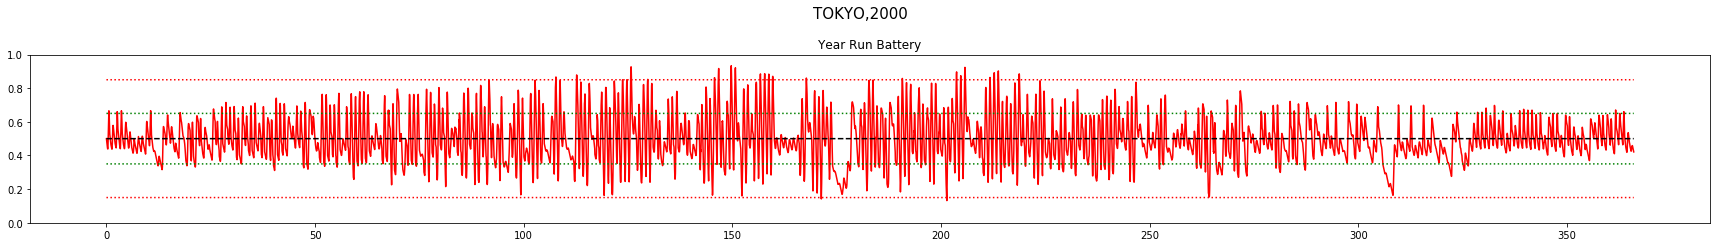



************************************
Day Violations           =      0
Battery Limit Violations =      0
Battery FULL Violations  =      0
Battery EMPTY Violations =      0


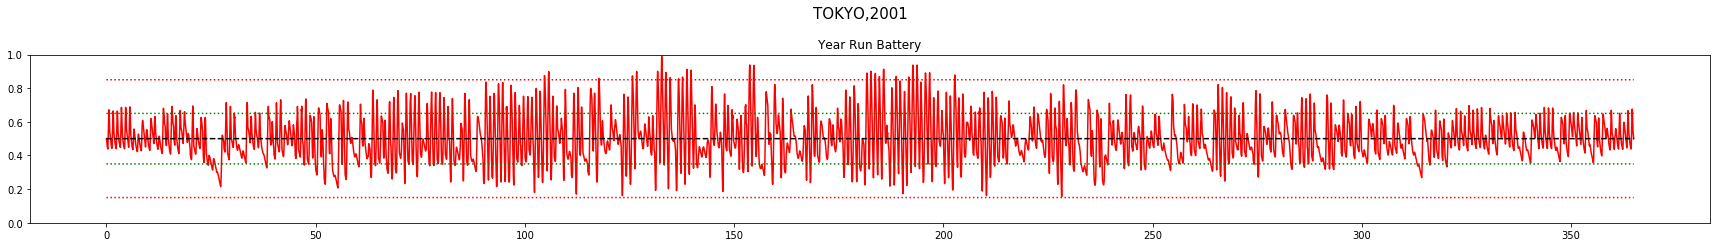



************************************
Day Violations           =      0
Battery Limit Violations =      0
Battery FULL Violations  =      0
Battery EMPTY Violations =      0


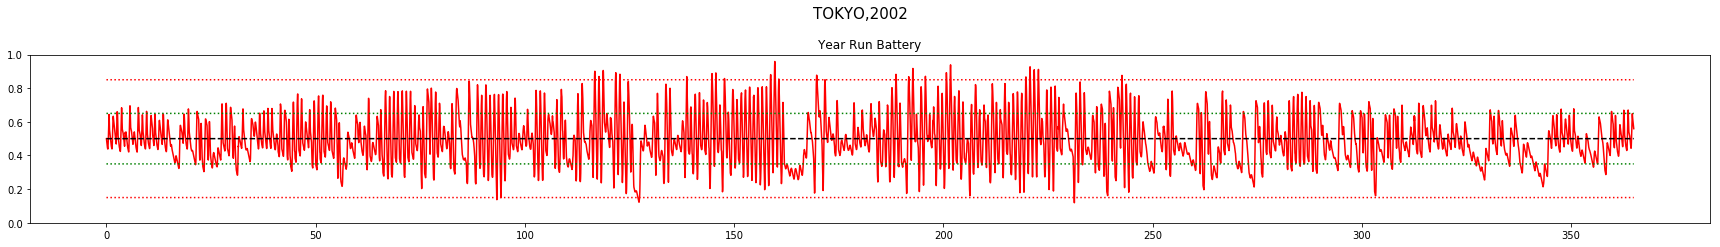



************************************
Day Violations           =      0
Battery Limit Violations =      0
Battery FULL Violations  =      0
Battery EMPTY Violations =      0


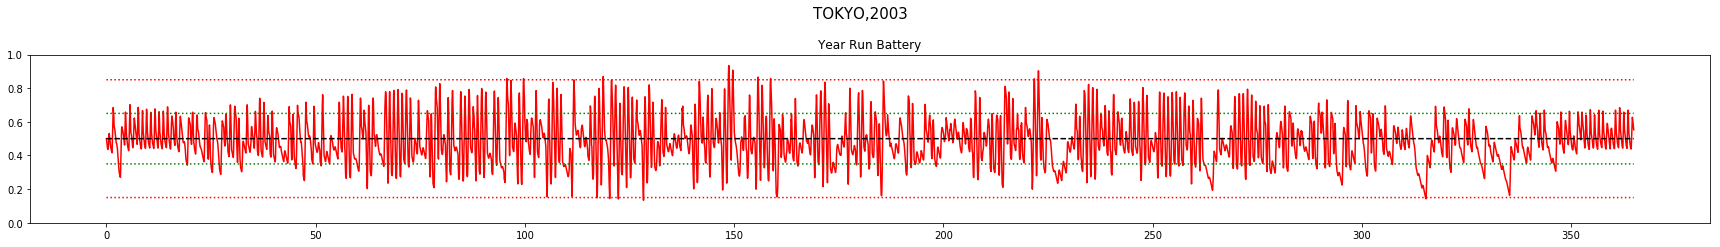



************************************
Day Violations           =      0
Battery Limit Violations =      0
Battery FULL Violations  =      0
Battery EMPTY Violations =      0


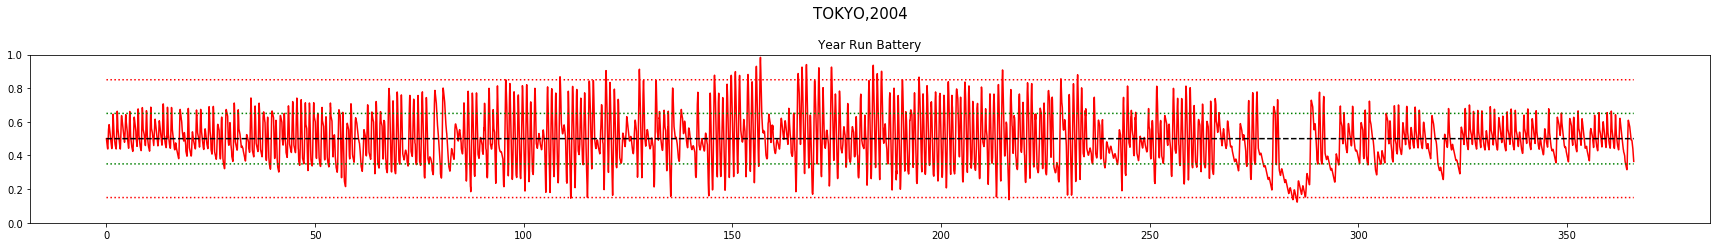



************************************
Day Violations           =      0
Battery Limit Violations =      0
Battery FULL Violations  =      0
Battery EMPTY Violations =      0


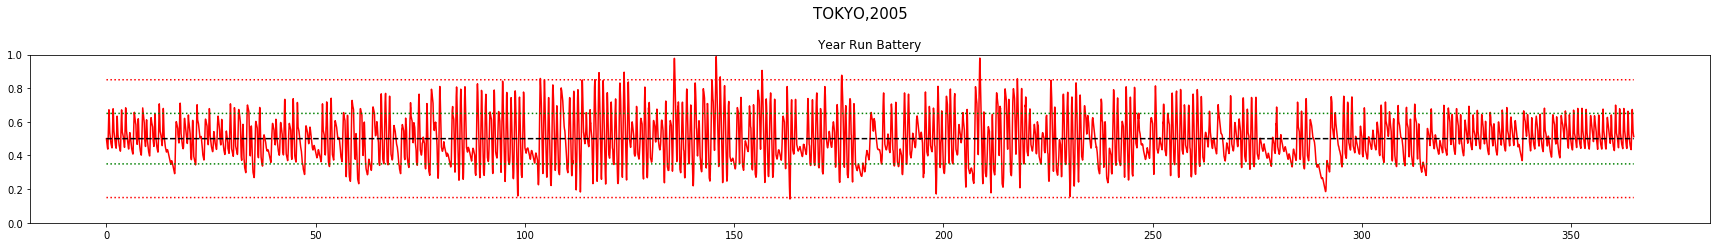



************************************
Day Violations           =      0
Battery Limit Violations =      0
Battery FULL Violations  =      0
Battery EMPTY Violations =      0


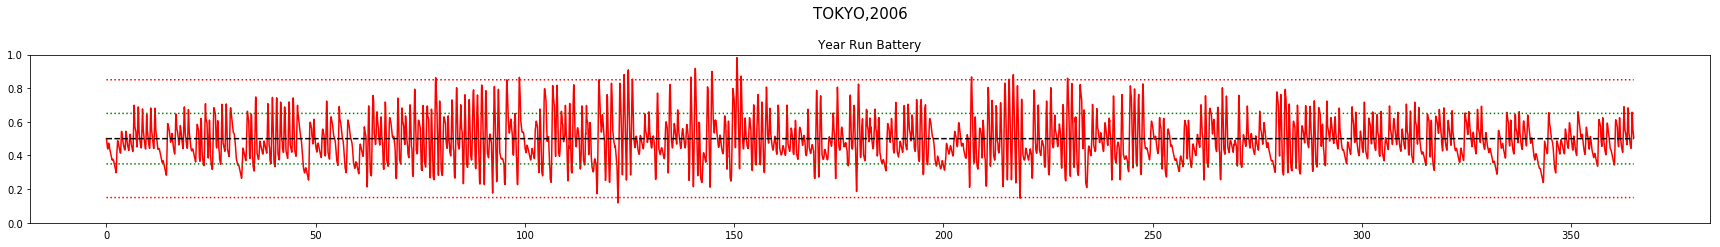



************************************
Day Violations           =      0
Battery Limit Violations =      0
Battery FULL Violations  =      0
Battery EMPTY Violations =      0


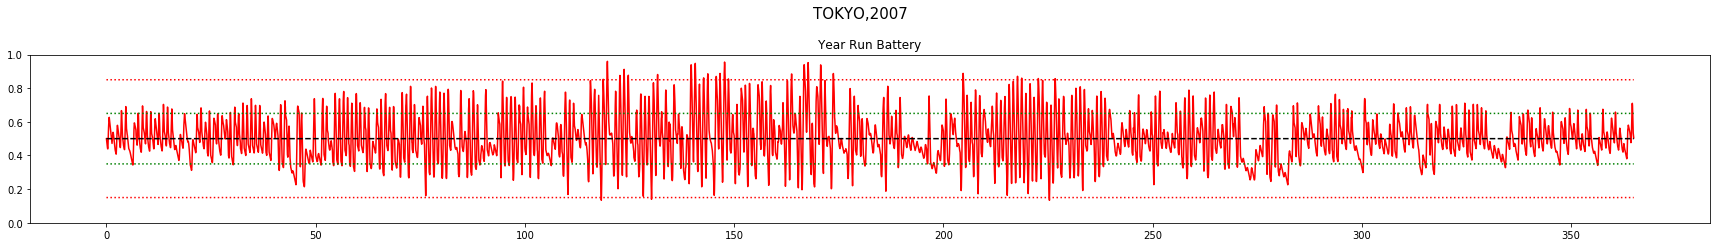



************************************
Day Violations           =      0
Battery Limit Violations =      0
Battery FULL Violations  =      0
Battery EMPTY Violations =      0


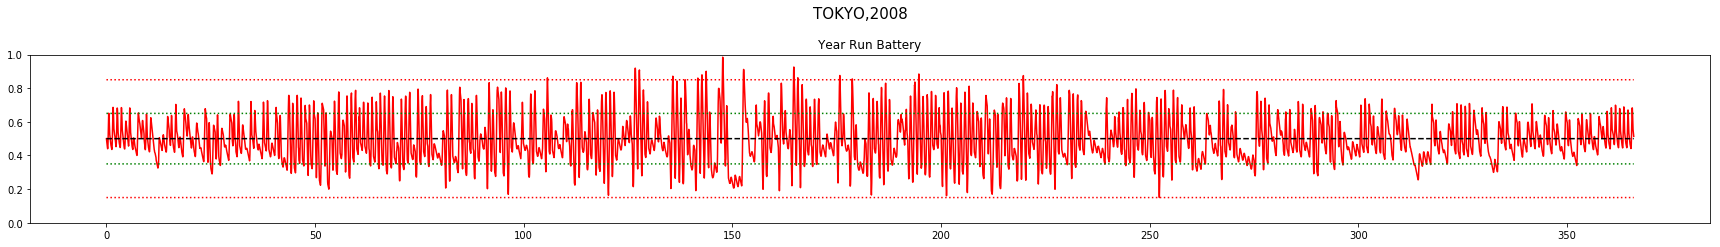



************************************
Day Violations           =      0
Battery Limit Violations =      0
Battery FULL Violations  =      0
Battery EMPTY Violations =      0


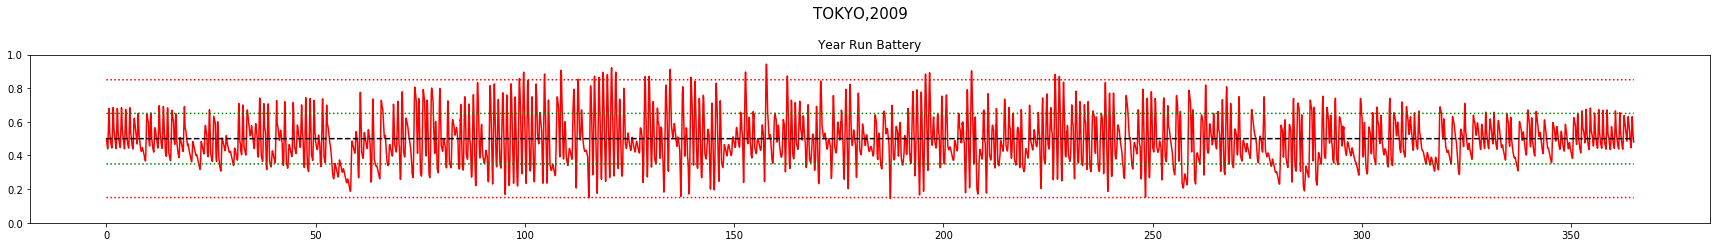



************************************
Day Violations           =      0
Battery Limit Violations =      0
Battery FULL Violations  =      0
Battery EMPTY Violations =      0


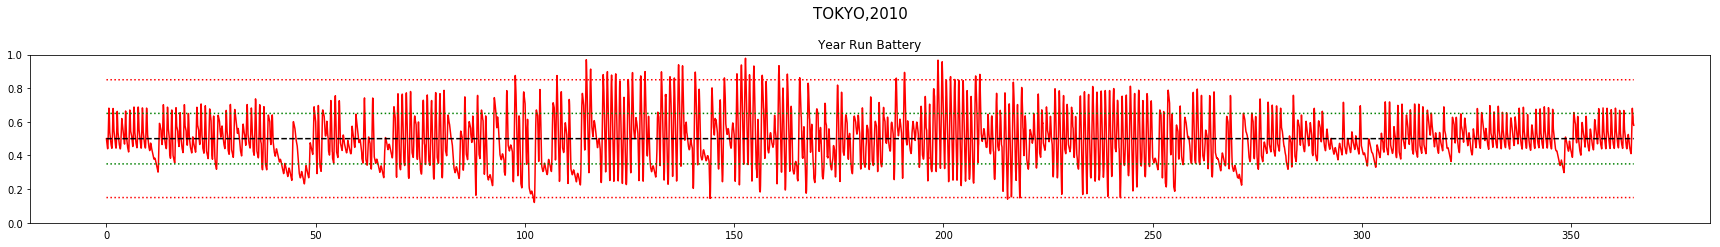



************************************
Day Violations           =      0
Battery Limit Violations =      0
Battery FULL Violations  =      0
Battery EMPTY Violations =      0


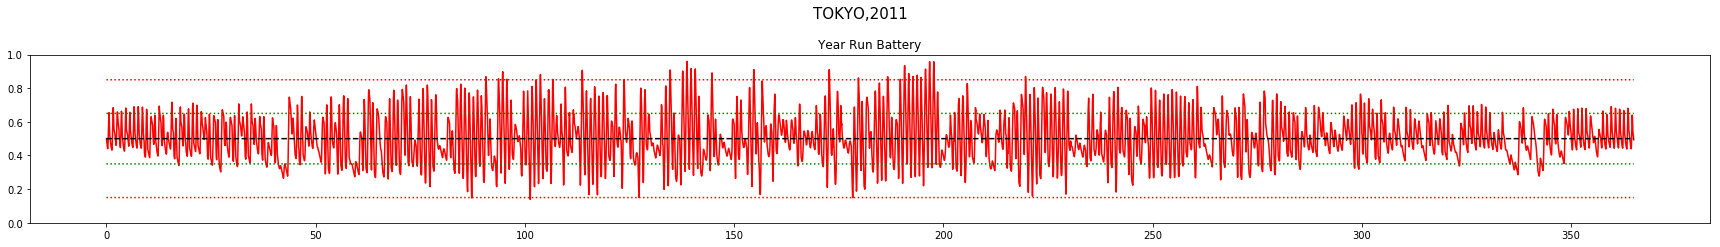



************************************
Day Violations           =      1
Battery Limit Violations =      1
Battery FULL Violations  =      1
Battery EMPTY Violations =      0


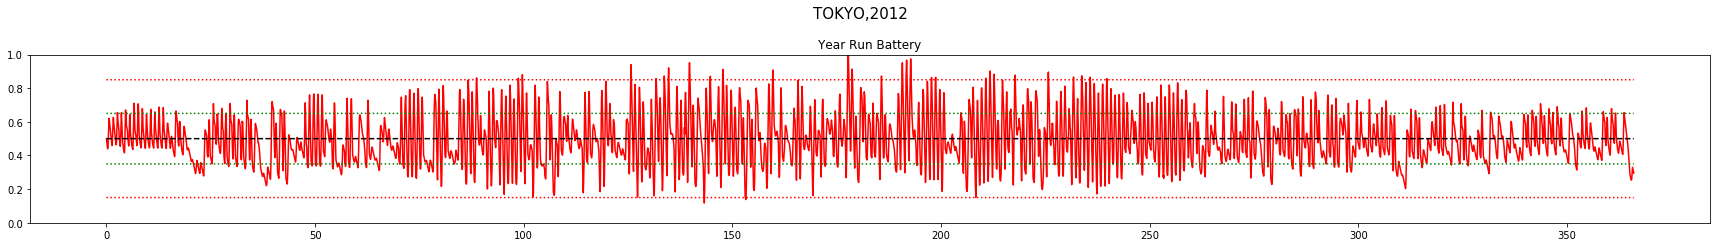



************************************
Day Violations           =      0
Battery Limit Violations =      0
Battery FULL Violations  =      0
Battery EMPTY Violations =      0


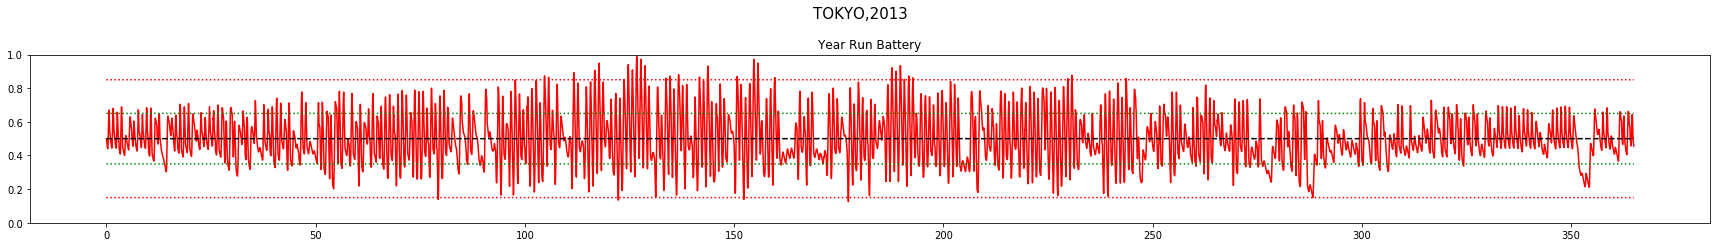



************************************
Day Violations           =      0
Battery Limit Violations =      0
Battery FULL Violations  =      0
Battery EMPTY Violations =      0


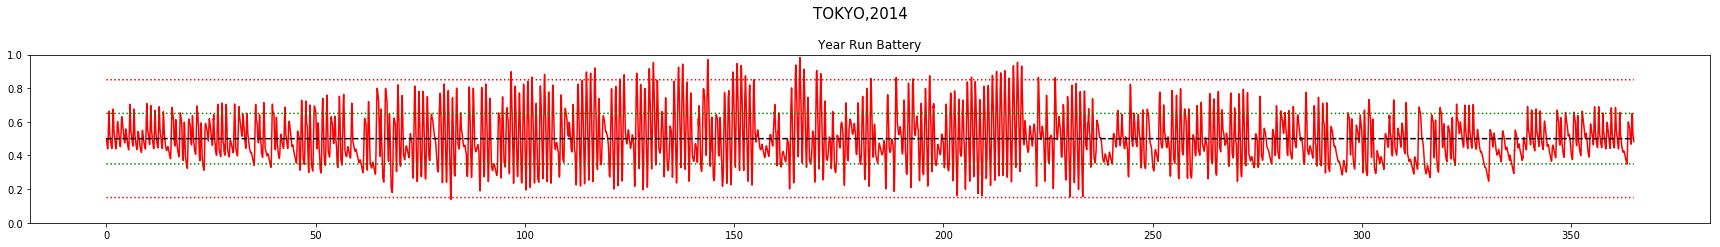



************************************
Day Violations           =      0
Battery Limit Violations =      0
Battery FULL Violations  =      0
Battery EMPTY Violations =      0


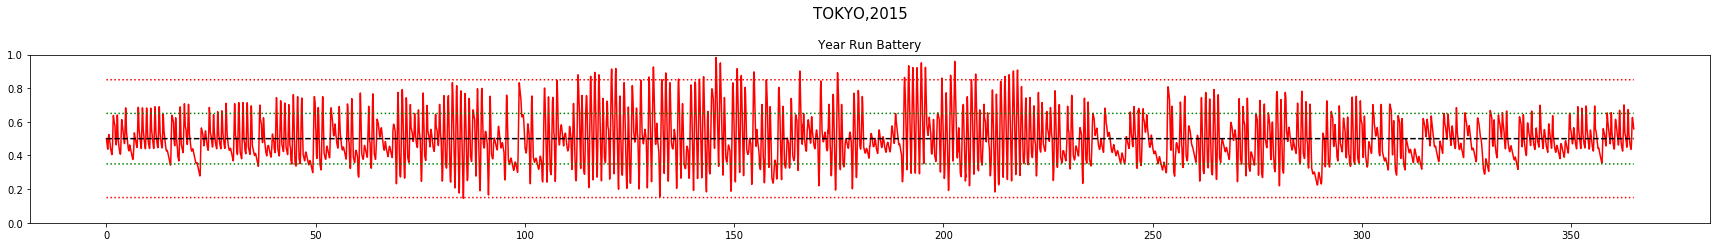



************************************
Day Violations           =      0
Battery Limit Violations =      0
Battery FULL Violations  =      0
Battery EMPTY Violations =      0


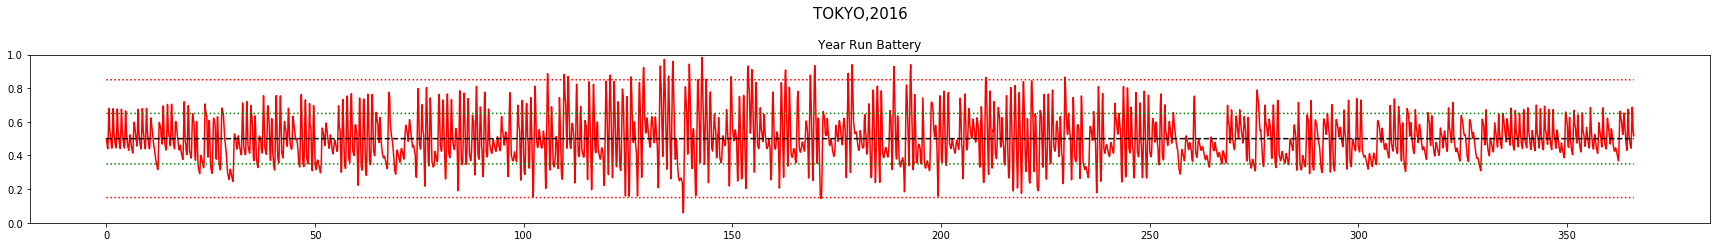



************************************
Day Violations           =      0
Battery Limit Violations =      0
Battery FULL Violations  =      0
Battery EMPTY Violations =      0


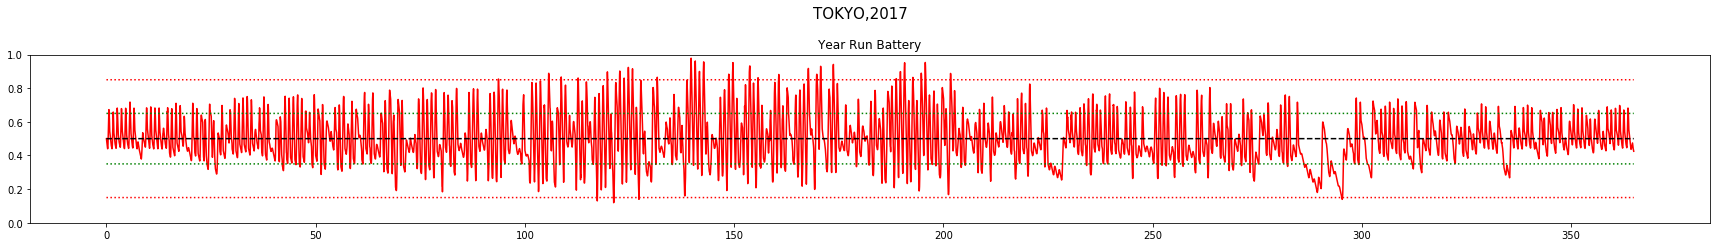



************************************
Day Violations           =      0
Battery Limit Violations =      0
Battery FULL Violations  =      0
Battery EMPTY Violations =      0


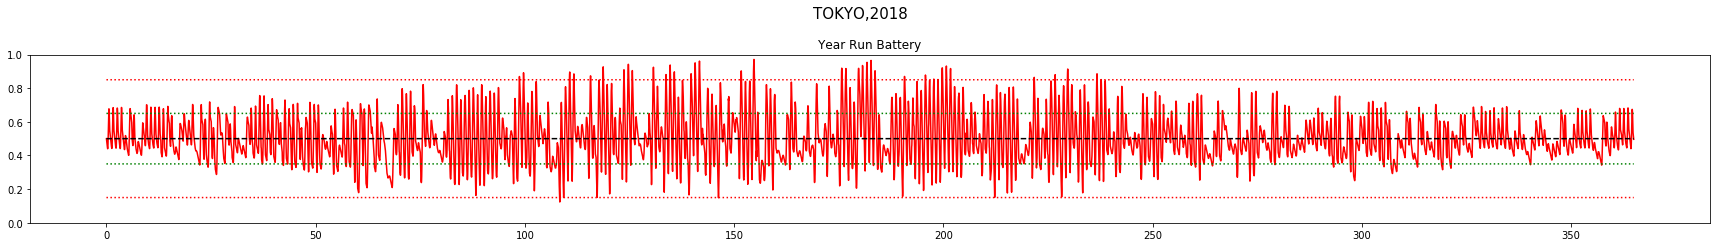



TOKYO
YEAR	AVG_RWD		VIOLATIONS	EMPTY	FULL
			DAY	BATT
2000	 1.98		0	 0	0	0
2001	 1.99		0	 0	0	0
2002	 1.99		0	 0	0	0
2003	 1.98		0	 0	0	0
2004	 1.96		0	 0	0	0
2005	 1.99		0	 0	0	0
2006	 1.99		0	 0	0	0
2007	 1.99		0	 0	0	0
2008	 1.98		0	 0	0	0
2009	 1.98		0	 0	0	0
2010	 1.99		0	 0	0	0
2011	 1.99		0	 0	0	0
2012	 1.99		1	 1	0	1
2013	 1.99		0	 0	0	0
2014	 1.99		0	 0	0	0
2015	 1.99		0	 0	0	0
2016	 1.99		0	 0	0	0
2017	 1.98		0	 0	0	0
2018	 1.99		0	 0	0	0

TOTAL Day  Violations:   1.0
TOTAL Batt  Violations:  1.0
TOTAL EMPTY Violations:  0.0
TOTAL FULL  Violations:  1.0
************************************


In [22]:
#VALIDATION PHASE
print("***MEASURING PERFORMANCE OF THE MODEL***")
# for LOCATION in ['tokyo']:#['wakkanai','aomori','tokyo','fukuoka','minamidaito']:
results = np.empty(6)
for YEAR in np.arange(2000,2019):
    capm      = CAPM(LOCATION,YEAR,shuffle=False, trainmode=False) #instantiate the CAPM class
    capm.eno  = ENO(LOCATION,YEAR, shuffle=False, day_balance=False) #instantiate the environment inside the CAPM class
    capm.HMAX = capm.eno.SMAX #maximum power output of solar cell is set in CAPM object using the value in ENO object

    s, r, day_end, year_end = capm.reset()
    yr_test_record = np.empty(4)

    while True:
        a = dqn.choose_greedy_action(stdize(s))
        yr_test_record = np.vstack((yr_test_record, [s[0],s[2],r, a])) #record battery, henergy, reward and action
        s_, r, day_end, year_end = capm.step(a)
        if year_end:
            break
        s = s_

    yr_test_record = np.delete(yr_test_record, 0, 0) #remove the first row which is garbage
    yr_test_reward_rec = yr_test_record[:,2]
    yr_test_reward_rec = yr_test_reward_rec[::24] #annual average reward
    results = np.vstack((results, [int(YEAR), np.mean(yr_test_reward_rec), int(capm.violation_counter), int(capm.batt_violations), int(capm.batt_empty_counter), int(capm.batt_full_counter)]))
    print("\n\n************************************")
    print("Day Violations           = {:6d}".format(capm.violation_counter))
    print("Battery Limit Violations = {:6d}".format(capm.batt_violations))
    print("Battery FULL Violations  = {:6d}".format(capm.batt_full_counter))
    print("Battery EMPTY Violations = {:6d}".format(capm.batt_empty_counter))
###########################################################################################
###########################################################################################
    #     Plot the reward and battery for the entire year run
    title = LOCATION.upper() + ',' + str(YEAR)
    NO_OF_DAYS = capm.eno.NO_OF_DAYS

    fig = plt.figure(figsize=(24,6))
    fig.suptitle(title, fontsize=15)

#         ax1 = fig.add_subplot(211)
#         ax1.plot(yr_test_reward_rec)
#         ax1.set_title("\n\nYear Run Reward")
#         ax1.set_ylim([-4,2])

    ax2 = fig.add_subplot(211)
    ax2.plot(yr_test_record[:,0],'r')
    ax2.plot(np.ones_like(yr_test_record[:,0])*capm.BOPT/capm.BMAX, 'k--')
    ax2.plot(np.ones_like(yr_test_record[:,0])*capm.BLIM_LO/capm.BMAX, 'r:')
    ax2.plot(np.ones_like(yr_test_record[:,0])*capm.BLIM_HI/capm.BMAX, 'r:')
    ax2.plot(np.ones_like(yr_test_record[:,0])*(capm.BOPT+capm.ENP_MARGIN /2) /capm.BMAX, 'g:')
    ax2.plot(np.ones_like(yr_test_record[:,0])*(capm.BOPT-capm.ENP_MARGIN/2)/capm.BMAX, 'g:')

    ax2.set_title("\n\nYear Run Battery")
    ax2.set_ylim([0,1])
    plt.sca(ax2)
    plt.xticks(np.arange(0, NO_OF_DAYS*24, 50*24),np.arange(0,NO_OF_DAYS,50))
    fig.tight_layout()
    plt.show()
###########################################################################################
###########################################################################################


results = np.delete(results,0,0)
print("\n")
print(LOCATION.upper())
print('YEAR\tAVG_RWD\t\tVIOLATIONS\tEMPTY\tFULL')
print('\t\t\tDAY\tBATT')

for x in np.arange(0,results.shape[0]):
    print('{}\t {}\t\t{}\t {}\t{}\t{}'.format(int(results[x,0]), np.around(results[x,1],2), int(results[x,2]), int(results[x,3]), int(results[x,4]),  int(results[x,5]) ))

print("\nTOTAL Day  Violations:  ",np.sum(results[:, 2]))
print("TOTAL Batt  Violations: ",np.sum(results[:,3]))
print("TOTAL EMPTY Violations: ",np.sum(results[:,4]))
print("TOTAL FULL  Violations: ",np.sum(results[:,5]))
print("************************************")

In [23]:
print('\nRun time: {}'.format(datetime.now() - tic))


Run time: 0:04:17.473916


In [24]:
# YEAR = 2000

In [25]:
# capm = CAPM(LOCATION,YEAR,shuffle=False, trainmode=False) #instantiate the CAPM class
# capm.eno = ENO(LOCATION,YEAR, shuffle=False, day_balance=False) #instantiate the environment inside the CAPM class
# capm.HMAX = capm.eno.SMAX #maximum power output of solar cell is set in CAPM object using the value in ENO object

# s, r, day_end, year_end = capm.reset()
# yr_test_record = np.empty(4)

# while True:
#     a = dqn.choose_greedy_action(stdize(s))

#     #state = [batt, enp, henergy, fcast]
#     yr_test_record = np.vstack((yr_test_record, [s[0],s[2],r, a])) #record battery, henergy, reward and action

#     # take action
#     s_, r, day_end, year_end = capm.step(a)

#     if year_end:
#         break

#     s = s_

# yr_test_record = np.delete(yr_test_record, 0, 0) #remove the first row which is garbage
# yr_test_reward_rec = yr_test_record[:,2]
# yr_test_reward_rec = yr_test_reward_rec[::24]

# title = LOCATION.upper() + ',' + str(YEAR)
# NO_OF_DAYS = capm.eno.NO_OF_DAYS

# fig = plt.figure(figsize=(24,6))
# fig.suptitle(title, fontsize=15)

# #     ax1 = fig.add_subplot(211)
# #     ax1.plot(yr_test_reward_rec)
# #     ax1.set_title("\n\nYear Run Reward")
# #     ax1.set_ylim([-3,3])

# #Plot the reward and battery for the entire year run
# ax2 = fig.add_subplot(111)
# ax2.plot(yr_test_record[:,0],'r')
# ax2.plot(np.ones_like(yr_test_record[:,0])*capm.BOPT/capm.BMAX, 'k--')
# ax2.plot(np.ones_like(yr_test_record[:,0])*capm.BLIM_LO/capm.BMAX, 'r:')
# ax2.plot(np.ones_like(yr_test_record[:,0])*capm.BLIM_HI/capm.BMAX, 'r:')
# ax2.plot(np.ones_like(yr_test_record[:,0])*(capm.BOPT+capm.ENP_MARGIN /2) /capm.BMAX, 'g:')
# ax2.plot(np.ones_like(yr_test_record[:,0])*(capm.BOPT-capm.ENP_MARGIN/2)/capm.BMAX, 'g:')
# ax2.set_title("\n\nYear Run Battery")
# ax2.set_ylim([0,1])
# plt.sca(ax2)
# plt.xticks(np.arange(0, NO_OF_DAYS*24, 50*24),np.arange(0,NO_OF_DAYS,50))
# fig.tight_layout()
# plt.show()

In [26]:
# DAY_START = 320
# DAY_END   = 325

In [27]:
# #Plot the reward and battery for the entire year run on a day by day basis
# title = LOCATION.upper() + ',' + str(YEAR)
# TIME_AXIS = np.arange(0,capm.eno.TIME_STEPS)
# for DAY in range(DAY_START,DAY_END):
#     START = DAY*24
#     END = START+24

#     daytitle = title + ' - DAY ' + str(DAY)
#     fig = plt.figure(figsize=(16,4))
#     st = fig.suptitle(daytitle)

#     ax2 = fig.add_subplot(121)
#     ax2.plot(yr_test_record[START:END,1],'g')
#     ax2.set_title("HARVESTED ENERGY")
#     ax2.set_xlabel("Hour")
#     ax2.set_ylim([0,1.05])
    
#     ax2.text(0.1, 0.6, "TENP = %.2f\n" %(capm.BOPT/capm.BMAX-yr_test_record[END,0]),fontsize=11, ha='left')
#     ax2.text(0.1, 0.5, "BMEAN = %.2f\n" %(np.mean(yr_test_record[START:END,0])),fontsize=11, ha='left')
#     ax2.text(0.1, 0.4, "BINIT = %.2f\n" %(yr_test_record[START,0]),fontsize=11, ha='left')
#     if END < (capm.eno.NO_OF_DAYS*capm.eno.TIME_STEPS):
#         ax2.text(0.1, 0.1, "REWARD = %.2f\n" %(yr_test_record[END,2]),fontsize=13, ha='left')
        
#     #plot battery for year run
#     ax1 = fig.add_subplot(122)
#     ax1.plot(TIME_AXIS,              yr_test_record[START:END,0],'r')
#     ax1.plot(TIME_AXIS, np.ones_like(yr_test_record[START:END,0])*capm.BOPT/capm.BMAX, 'r--')
#     ax1.plot(TIME_AXIS, np.ones_like(yr_test_record[START:END,0])*capm.BLIM_LO/capm.BMAX, 'r-.',alpha=0.5)
#     ax1.plot(TIME_AXIS, np.ones_like(yr_test_record[START:END,0])*capm.BLIM_HI/capm.BMAX, 'r-.',alpha=0.5)
#     ax1.plot(TIME_AXIS, np.ones_like(yr_test_record[START:END,0])*(capm.BOPT+capm.ENP_MARGIN /2) /capm.BMAX, 'g:',alpha=0.5)
#     ax1.plot(TIME_AXIS, np.ones_like(yr_test_record[START:END,0])*(capm.BOPT-capm.ENP_MARGIN/2)/capm.BMAX, 'g:',alpha=0.5)
    
#     ax1.set_title("YEAR RUN TEST")
#     ax1.set_xlabel("Hour")
#     ax1.set_ylabel('Battery', color='r',fontsize=12)
#     ax1.set_ylim([-0.05,1.05])

#     #plot actions for year run
#     ax1a = ax1.twinx()
#     ax1a.plot(yr_test_record[START:END,3]+1)
#     ax1a.set_ylim([0,N_ACTIONS])
#     ax1a.set_ylabel('Duty Cycle', color='b',fontsize=12)
#     ax1a.set_ylim([0,10.25])


#     fig.tight_layout()
#     st.set_y(0.95)
#     fig.subplots_adjust(top=0.75)
#     plt.show()